## Using SOFIE with RDataFrame in Python

This is an example on how to perform ML inference with RDataFrame in Python. 

In this example we are going to start from the Keras input model file and use SOFIE and then the ROOT JIT to compile the model.

Notebook derived from the tutorial [TMVA_SOFIE_RDataFrame.py](https://root.cern.ch/doc/master/TMVA__SOFIE__RDataFrame_8py.html)



In [1]:
import ROOT

Welcome to JupyROOT 6.29/01


In [2]:
modelFile = "Higgs_trained_model.h5"
if (ROOT.gSystem.AccessPathName(modelFile)) :
    ROOT.Info("TMVA_SOFIE_RDataFrame","You need to run TMVA_Higgs_Classification to generate the Keras trained model")
    exit()


### Parse input file (directly from Keras)

Parse the input file using the direct Keras to RModel converter

In [3]:
# parse the input Keras model into RModel object
model = ROOT.TMVA.Experimental.SOFIE.PyKeras.Parse(modelFile)

Keras Version: 2.9.0
Model has not a defined batch size, assume is 1 - input shape for tensor dense_input : { 1 , 7 }


#### Generate the inference C++ code

In [5]:
#Generating inference code
model.Generate()
model.OutputGenerated("model.hxx")
#model.PrintGenerated()

### Compile generated model using ROOT JIT

In [6]:
# now compile using ROOT JIT trained model
print("compiling SOFIE model and functor....")
generatedFile = "model.hxx"
modelName = "Higgs_trained_model"
ROOT.gInterpreter.Declare('#include "' + generatedFile + '"')

compiling SOFIE model and functor....


True

Declare the SOFIE functor to be used by RDataFrame. 
We instantiate it in C++ and use `gInterpreter.Declare`to have it available by the ROOT interpreter

In [ ]:
#sofie_functor = ROOT.TMVA.Experimental.SofieFunctor[7,'TMVA_SOFIE_Higgs_trained_model::Session'](0)

In [7]:
ROOT.gInterpreter.Declare('auto sofie_functor = TMVA::Experimental::SofieFunctor<7,TMVA_SOFIE_'+modelName+'::Session>(0);')

True

### Use model with RDataFrame

In [8]:
inputFile = "http://root.cern.ch/files/Higgs_data.root"

In [9]:
df1 = ROOT.RDataFrame("sig_tree", inputFile)
h1 = df1.Define("DNN_Value", "sofie_functor(rdfslot_,m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb)").Histo1D(("h_sig", "", 100, 0, 1),"DNN_Value")


In [10]:
df2 = ROOT.RDataFrame("bkg_tree", inputFile)
h2 = df2.Define("DNN_Value", "sofie_functor(rdfslot_,m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb)").Histo1D(("h_bkg", "", 100, 0, 1),"DNN_Value")

In [11]:
ROOT.RDF.RunGraphs([h1, h2])

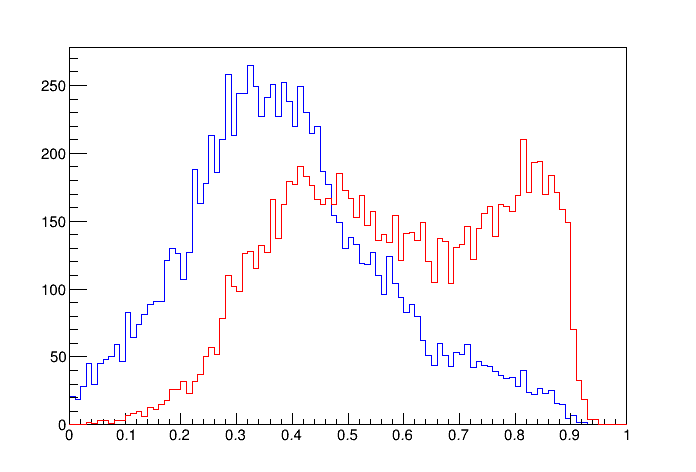

In [12]:
h1.SetLineColor(ROOT.kRed)
h2.SetLineColor(ROOT.kBlue)

c1 = ROOT.TCanvas()
ROOT.gStyle.SetOptStat(0)

h2.Draw()
h1.Draw("SAME")
c1.Draw()